In [1]:
import numpy as np
import matplotlib.pyplot as plt
from   mpl_toolkits.mplot3d import Axes3D

In [2]:
from numpy.linalg import slogdet
from numpy.linalg import inv

In [3]:
def extractVars(js,x):
    if x.ndim == 1:
        return x[js]
    return x[js][:,js]

In [4]:
class G():
    def __init__(self,m,c=None,ic=None):
        self.m = np.array(m)
        self.dim = len(m)
        if ic is not None:
            self.ic = np.array(ic)
            self.c  = inv(ic)
            return
        if c is not None:
            self.c = np.array(c)
            self.ic = inv(c)
            return
        self.c  = np.eye(len(m))
        self.ic = np.eye(len(m))
    
    def marg(self,js):
        m = extractVars(js,self.m)
        c = extractVars(js,self.c)
        return G(m,c)
    
    def cond(self,y):
        ny = len(y)
        nx = len(self.m) - ny
        mx = self.m[:nx]
        my = self.m[nx:]
        cxx = self.c[:nx][:,:nx]
        cyy = self.c[nx:][:,nx:]
        cxy = self.c[:nx][:,nx:]
        cyx = cxy.T
        r = cxy @ inv(cyy)
        m = mx + r @ (y-my)
        c = cxx - r @ cyx
        return G(m,c)
    
    # a linear transformation of x is convolved with (suffers additive noise)
    # with offset o and covariance r 
    # x ~ N m c,   y|x ~ N (h x + o,  r)
    def jointLinear(self, h, n):
        h = np.array(h)
        o = n.m
        r = n.c
        m = np.append(self.m, h @ self.m + o)
        cxy = self.c @ h.T
        cyy = h @ cxy + r
        c = np.bmat([[self.c  , cxy],
                     [cxy.T   , cyy]])
        return G(m, np.array(c))
    
    
    # direct, alternative method
    def bayesGaussianLinear(self,h,n,y):
        h = np.array(h)
        c = inv(self.ic + h.T @ n.ic @ h)
        m = c @ (h.T @ n.ic @ (y-n.m) + self.ic @ self.m)
        return G(m,c)
    
    
    # kalman-style method
    def bayesGaussianLinearK(self,h,n,y):
        h = np.array(h)
        k = self.c @ h.T @ inv (h @ self.c @ h.T + n.c)
        c = (np.eye(len(self.m)) - k @ h) @ self.c
        m = self.m + k @ (y - h @ self.m - n.m)
        return G(m,c)

    
    def logprob(self):
        l1 = -self.dim/2 * np.log(2*np.pi)
        l2 = -1/2 * slogdet(self.c)[1]
        l3 = lambda x: -0.5* (x-self.m) @ self.ic @ (x-self.m)
        return lambda x: l1 + l2 + l3(x)
    
    def ellipse(self):
        assert self.dim == 2
        
        l,v = np.linalg.eigh(self.c)

        sl1 = np.sqrt(l[0])
        sl2 = np.sqrt(l[1])
        v1 = v[:,0]
        v2 = v[:,1]

        CIR = np.array([ [np.cos(t), np.sin(t)] for t in np.linspace(0,2*np.pi, 50) ])

        def rot(a):
            c = np.cos(a)
            s = np.sin(a)
            return np.array([[c,-s],
                             [s, c]])

        return self.m + CIR @ np.diag([2*sl2,2*sl1]) @ rot(-np.arctan2(v2[1],v2[0]))



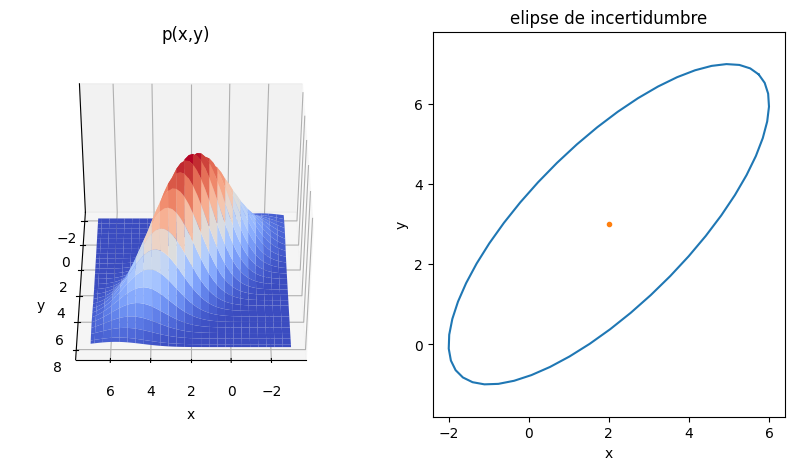

In [5]:
g = G([2,3], [[4,3],
              [3,4]])

fig = plt.figure(figsize=(10,5))
x = np.linspace(-3,7,50)
y = np.linspace(-2,8,50)
x1,x2 = np.meshgrid(x,y)
gxy = g.logprob()
z = np.array([[np.exp(gxy(np.array([x,y]))) for x in x] for y in y])

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1,x2,z, cmap='coolwarm', linewidth=0.5, rstride=2, cstride=2);
ax.view_init(elev=40,azim=90)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_title('p(x,y)'); ax.set_zticks([])

plt.subplot(1,2,2)
plt.plot(*g.ellipse().T);
plt.plot(*g.m,'.');
plt.xlabel('x'); plt.ylabel('y'); plt.title('elipse de incertidumbre'); plt.axis('equal');

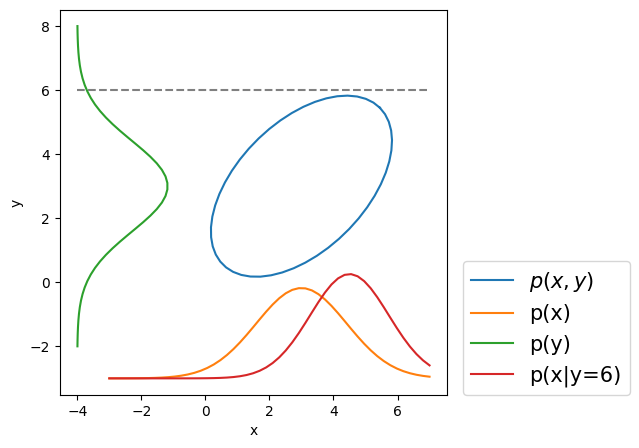

In [6]:
g = G([3,3], [[2,1],
              [1,2]])

plt.figure(figsize=(5,5))
plt.plot(*g.ellipse().T, label='$p(x,y)$');
px = g.marg([0]).logprob()
py = g.marg([1]).logprob()
plt.plot(x, [-3+10*np.exp(px(x)) for x in x], label='p(x)');
plt.plot([-4+10*np.exp(py(y)) for y in y], y, label='p(y)');
gx = g.cond([6]).logprob()
plt.plot(x, [-3+10*np.exp(gx(x)) for x in x], label='p(x|y=6)');
plt.plot([-4,7],[6,6],ls='dashed',color='gray');
plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal');
plt.legend(loc=(1.04,0), fontsize=15);

[0 5]
[[ 4  8]
 [ 8 17]]


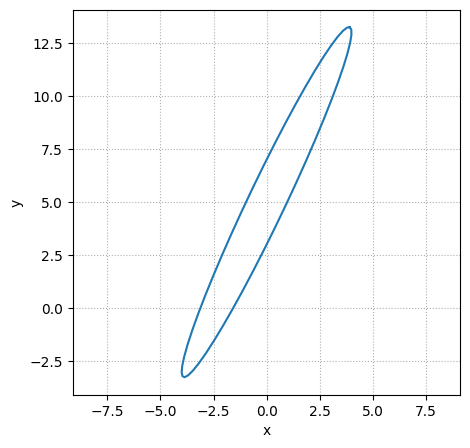

In [7]:
g = G([0],[[4]]).jointLinear([[2]], G([5], [[1]]))

plt.figure(figsize=(5,5))
plt.plot(*g.ellipse().T); plt.axis('equal'); plt.grid(ls='dotted');
plt.xlabel('x'); plt.ylabel('y');
print(g.m)
print(g.c)

In [8]:
# se condiciona los últimos elementos del vector
g = g.cond([0])
g.m, g.c

(array([-2.35294118]), array([[0.23529412]]))

In [9]:
g = G([0],[[4]]).bayesGaussianLinearK([[2]], G([5],[[1]]), [0])
g.m, g.c

(array([-2.35294118]), array([[0.23529412]]))

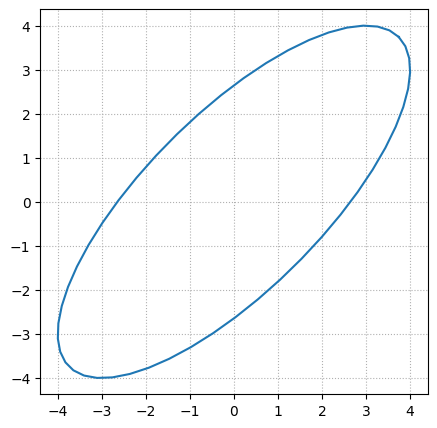

In [10]:
g = G([0,0] , [[4,3],
               [3,4]])

plt.figure(figsize=(5,5))
plt.plot(*g.ellipse().T); plt.axis('equal'); plt.grid(ls='dotted');

In [11]:
error = np.diag([0.4,0.1])
g.jointLinear(np.eye(2), G([0,0], error)).c

array([[4. , 3. , 4. , 3. ],
       [3. , 4. , 3. , 4. ],
       [4. , 3. , 4.4, 3. ],
       [3. , 4. , 3. , 4.1]])

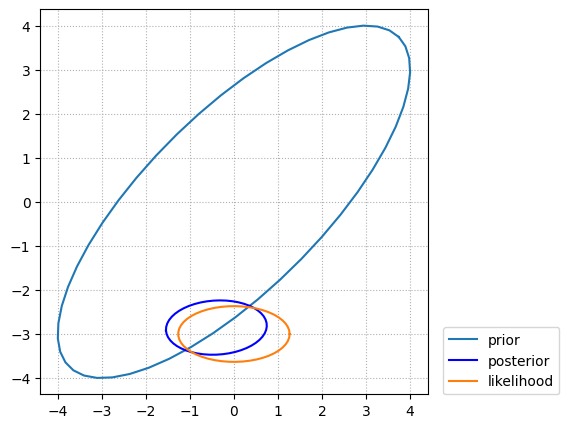

In [12]:
obs = [0,-3]
plt.figure(figsize=(5,5))
plt.axis('equal');
post = g.bayesGaussianLinear(np.eye(2), G([0,0], error),  obs)
plt.plot(*g.ellipse().T, label='prior');
plt.plot(*post.ellipse().T, label='posterior', color='blue');
plt.plot(*G(obs,  error).ellipse().T, label='likelihood');
plt.grid(ls='dotted'); plt.legend(loc=(1.04,0));

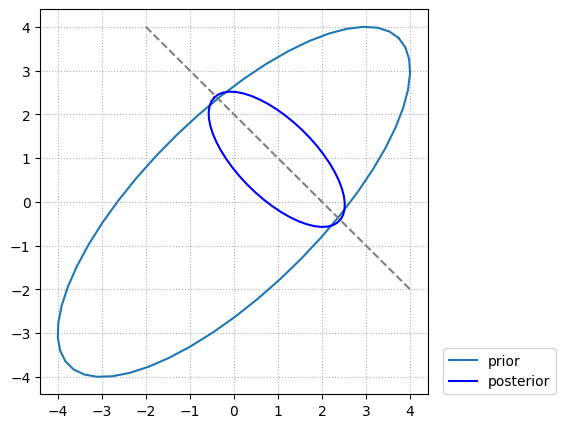

In [13]:
plt.figure(figsize=(5,5))
post = g.bayesGaussianLinear([[1,1]], G([0], [[0.4]]),  [2] )
plt.plot(*g.ellipse().T, label='prior');
plt.plot(*post.ellipse().T, label='posterior', color='blue');
plt.grid(ls='dotted'); plt.legend(loc=(1.04,0));
plt.plot([-2,4],[4,-2],color='gray',ls='dashed');

In [14]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

degree = np.pi/180

In [15]:
def mikalman(mu,P,F,Q,B,u,z,H,R):
    # mu, P : estado actual y su incertidumbre
    # F, Q  : sistema dinámico y su ruido
    # B, u  : control model y la entrada
    # z     : observación
    # H, R  : modelo de observación y su ruido

    mup = F @ mu + B @ u;
    pp  = F @ P @ F.T + Q;

    zp = H @ mup

    # si no hay observación solo hacemos predicción
    if z is None:
        return mup, pp, zp

    epsilon = z - zp

    k = pp @ H.T @ np.linalg.inv(H @ pp @ H.T +R)

    new_mu = mup + k @ epsilon;
    new_P  = (np.eye(len(P))-k @ H) @ pp;
    return new_mu, new_P, zp

In [16]:
def unscentedSamples(m,c):
    n = len(m)
    alpha = 0.5
    beta = 2
    kappa = 3 - n
    lamda = alpha**2 * (n + kappa) - n
    ds = la.cholesky((n+lamda)*c).T
    ws = np.ones(2*n)*(1/2/(n+lamda))
    wm = np.hstack([lamda/(n+lamda), ws])
    wc = np.hstack([lamda/(n+lamda) + 1 - alpha**2 + beta,ws])
    s = np.asarray(np.vstack([m,m+ds,m-ds]))
    return s,wm,wc

In [17]:
def unscentCov(wc,xcen,ycen):
    rx,cx = xcen.shape
    _,cy  = ycen.shape
    xy = np.zeros([cx,cy])
    for k in range(rx):
        xy += wc[k]* xcen[[k],:].T @ ycen[[k],:]
    return xy

def unscentEstimate(s,wm,wc):
    m = np.sum(np.diag(wm)@s,axis=0)
    sc = s-m
    c = unscentCov(wc,sc,sc)
    return m,c

In [18]:
def ukf(mu,P,F,Q,B,u,z,H,R):
    # mu, P : estado actual y su incertidumbre
    # F, Q  : sistema dinámico (función general) y su ruido
    # B, u  : control model (también función general) y la entrada
    # z     : observación (puede ser None)
    # H, R  : modelo de observación (función general) y su ruido

    ns = len(mu)
    nz = len(R)
    
    def Z(n,m): return np.zeros([n,m])
    
    mua = np.concatenate([mu, np.zeros(ns+nz)])
    Pa  = np.bmat(
        [[ P        , Z(ns,ns) , Z(ns,nz) ],
         [ Z(ns,ns) , Q        , Z(ns,nz) ],
         [ Z(nz,ns) , Z(nz,ns) , R        ]])
    
    s,wm,wc = unscentedSamples(mua,Pa)
    
    s_x = s[:,:ns]
    s_f = s[:,ns:ns+ns]
    s_r = s[:,ns+ns:]
    
    b = B(u)
    st = np.array([F(x) + b +r for x,r in zip(s_x, s_f)])
    mup,pp = unscentEstimate(st,wm,wc)
    
    sz = np.array([H(x) + r for x,r in zip(st, s_r)])
    muz = np.sum(np.diag(wm) @ sz, axis=0)
    
    szc = sz-muz
    zc = unscentCov(wc,szc,szc)
    
    stc = st-mup
    xz = unscentCov(wc,stc,szc)

    K = xz @ la.inv(zc)

    if z is None:
        return mup, pp, muz

    new_mu = mup + K @ (z-muz)
    new_P  = pp - K @ zc @ K.T

    return new_mu, new_P, muz

In [19]:
import numpy        as np
import numpy.linalg as la
import cv2          as cv


def vec(*argn):
    return np.array(argn)


def col(*args):
    a = args[0]
    n = len(args)
    if n==1 and type(a) == np.ndarray and len(a.shape) == 1:
        return a.reshape(-1,1)
    return np.array(args).reshape(n,1)


def row(*args):
    return col(*args).T


def jc(*args):
    return np.hstack(args)


def jr(*args):
    return np.vstack(args)


def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)


def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]



def htrans(h,x):
    return inhomog(np.dot(homog(x) , h.T))


def kgen(sz,f):
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2,0,   w2],
                     [0,  f*w2, h2],
                     [0,   0,   1 ]])


# matriz de calibración sencilla dada la
# resolución de la imagen y el fov horizontal en grados
def Kfov(sz,hfovd):
    hfov = np.radians(hfovd)
    f = 1/np.tan(hfov/2)
    # print(f)
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2, 0,    w2],
                     [0,    f*w2, h2],
                     [0,    0,    1 ]])



def desp(d):
    n = len(d)
    D = np.eye(n+1)
    D[:n,-1] = d
    return D


def scale(s):
    return np.diag(np.append(s,1))


def unitary(v):
    return v / la.norm(v)


def rotation(v, a=None, homog=False):
    if a==None:
        R = cv.Rodrigues(v)[0]
    else:
        R = cv.Rodrigues(unitary(v)*a)[0]
    if homog:
        Rh = np.eye(4)
        Rh[:3,:3] = R
        return Rh
    else:
        return R


def rot3(ang):
    c = np.cos(ang)
    s = np.sin(ang)
    return np.array([[c,-s, 0]
                    ,[s, c, 0]
                    ,[0, 0, 1]])


def lookat(eye, target, up = (0, 0, 1)):
    z = np.asarray(target, np.float64) - eye  # target-eye
    z /= la.norm(z)
    x = np.cross(up, z)
    x /= la.norm(x)
    y = np.cross(z, x)
    R = np.float64([x, y, z])  # filas
    tvec = -np.dot(R, eye)
    return jc(R, col(tvec))


def lookat2(eye, target, up = (0, 0, 1)):
    z = np.asarray(target, np.float64) - eye  # target-eye
    z /= la.norm(z)
    x = np.cross(-np.array(up), z)  # "arriba" con y creciendo hacia abajo
    x /= la.norm(x)
    y = np.cross(z, x)
    R = np.float64([x, y, z])  # filas
    tvec = -np.dot(R, eye)
    return jc(R, col(tvec))



def rmsreproj(view,model,transf):
    err = view - htrans(transf,model)
    return np.sqrt(np.mean(err.flatten()**2))



class Pose:
    def __init__(self,K,image,model):
        is2D = model.shape[1] == 2
        if is2D:
            okmodel = np.hstack([model,np.zeros((len(model),1))])
        else:
            okmodel = model

        ok,rvec,tvec = cv.solvePnP(okmodel,image,K,vec(0.,0,0,0))
        if not ok:
            self.rms = 1e6
            return
        self.R,_  = cv.Rodrigues(rvec)
        self.M    = np.dot(K , jc(self.R,tvec))        
        self.view = htrans(self.M,okmodel)
        self.rms  = np.sqrt(np.mean((image - self.view).flatten()**2))
        self.t    = tvec.flatten()
        self.C    = np.dot(-self.R.T, self.t)


    #rms,M,R,t,C = ht.pose(K,image,okmodel)
    #assert(depthOfPoint(M,vec(0,0,0)>0))
    #R = M[:,:3]
    #t = np.dot(la.inv(K), M[:,3])
    #C = ht.inhomog(ht.null1(M))
    #assert C[2]<0, "bad side of the world"
    #return rms, M, R, t, htrans(M,okmodel)



def depthOfPoint(M,x):
    a = M[:,:3]
    m3 = a[2,:]
    w = np.dot(M , col(np.append(x,1)))
    w3 = w[2,0]
    return np.sign(la.det(a))/la.norm(m3)*w3


# espacio nulo de una matriz que sirve para obtener el centro
# de la cámara
def null1(M):
    u,s,vt = la.svd(M)
    return vt[-1,:]


def rq(M):
    Q,R = la.qr(np.flipud(np.fliplr(M)).T)
    R   = np.fliplr(np.flipud(R.T))
    Q   = np.fliplr(np.flipud(Q.T))
    return R,Q


# descomposición de la matriz de cámara como K,R,C
def sepcam(M):

    K,R = rq (M[:,:3])

    # para corregir los signos de f dentro de K
    s = np.diag(np.sign(np.diag(K)))

    K = np.dot(K , s)
    K = K/K[2,2]

    R = np.dot(s , R)
    R = R*np.sign(la.det(R))

    C = inhomog(null1(M))

    return K,R,C


##########################################################

def rot1b(a):
    T3 = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,1]])
    P  = np.eye(4)[:3]
    return P @ desp((0,0,1)) @ rotation((1,0,0),a,homog=True) @ desp((0,0,-1)) @ T3


def tiltH(K,d,a,b=0):
    H = K @ rot3(np.radians(-d)) @ rot1b(np.radians(-a)) @ rot3(np.radians(d+b)) @ la.inv(K)
    return H


def f_from_hfov(hfov):
    return 1/np.tan(hfov/2)


def tilt(fov,d,a,b,x):
    h,w = x.shape[:2]
    K = kgen((w,h),f_from_hfov(np.radians(fov)))
    H = tiltH(K,d,a,b)
    return cv.warpPerspective(x,H,(w,h))


def untilt(fov,d,a,b,x):
    h,w = x.shape[:2]
    K = kgen((w,h),f_from_hfov(np.radians(fov)))
    H = tiltH(K,d,a,b)
    return cv.warpPerspective(x,la.inv(H),(w,h))



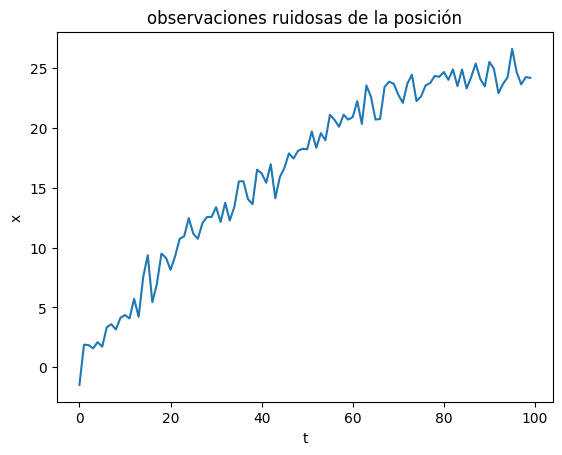

In [20]:
v0 = 0.5
a = -0.005
dt = 1
t = np.arange(0,100,dt)

sigmaR = 1
zp = v0*t + 1/2*a*t**2
zs = zp + sigmaR*np.random.randn(len(t));

plt.plot(t,zs);
plt.title("observaciones ruidosas de la posición"); plt.xlabel("t"); plt.ylabel("x");

In [21]:
# modelo de evolución del sistema
f = np.array(
    [[1, dt],
     [0,  1]])

# control
B = np.array([[dt**2/2],[dt]])
u = np.array([a])

# el ruido del proceso se puede poner como incertidumbre en la aceleración
sigmaa = np.array([[abs(a/100)]])
s = B @ sigmaa**2 @ B.T

In [22]:
#modelo de la observación
H = np.array([[1,0]])

#y su ruido
r = np.array([[sigmaR**2]])

In [23]:
#el estado inicial
mu0 = np.array([5,0])

p0 = np.array(
    [[100000, 0],
     [0, 100000]])

In [24]:
mu = mu0
p = p0

res = np.array([[mu[0],mu[1],np.sqrt(p[0,0]),np.sqrt(p[1,1])]])

for z in zs:
    mu,p,_ = mikalman(mu,p,f,s,B,u,z,H,r)
    res = np.append(res,[[mu[0],mu[1],np.sqrt(p[0,0]),np.sqrt(p[1,1])]],axis=0)

print(res[:10])

[[ 5.00000000e+00  0.00000000e+00  3.16227766e+02  3.16227766e+02]
 [-1.48475779e+00 -3.24612890e+00  9.99997500e-01  2.23607357e+02]
 [ 1.88397877e+00  3.36603806e+00  9.99990001e-01  1.41416760e+00]
 [ 2.41202234e+00  1.65975838e+00  9.12867126e-01  7.07097944e-01]
 [ 2.32127944e+00  9.05619072e-01  8.36657995e-01  4.47210356e-01]
 [ 2.54473573e+00  6.74065640e-01  7.74595379e-01  3.16226190e-01]
 [ 2.42881589e+00  4.54297455e-01  7.23745957e-01  2.39044826e-01]
 [ 3.09375024e+00  4.98482788e-01  6.81384463e-01  1.88981677e-01]
 [ 3.59196414e+00  4.93929010e-01  6.45496691e-01  1.54302980e-01]
 [ 3.72969175e+00  4.26511206e-01  6.14635866e-01  1.29099193e-01]]


In [25]:
print(res[-5:])

[[2.48890352e+01 2.47956442e-02 2.02588761e-01 3.69495751e-03]
 [2.49008683e+01 1.96327905e-02 2.01560021e-01 3.63845964e-03]
 [2.48666465e+01 1.38415875e-02 2.00546901e-01 3.58341232e-03]
 [2.48531063e+01 8.46211218e-03 1.99549014e-01 3.52976458e-03]
 [2.48325129e+01 3.06115640e-03 1.98565985e-01 3.47746774e-03]]


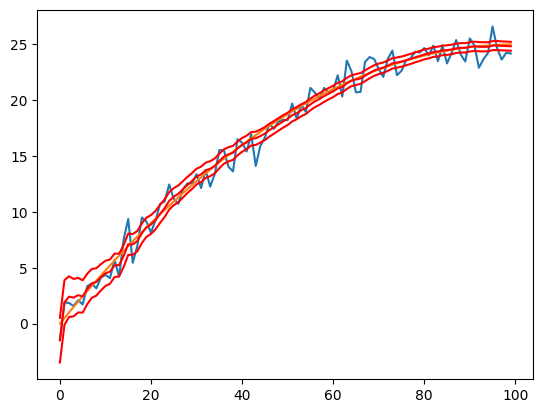

In [26]:
plt.plot(t,zs,t,zp);
plt.plot(t,res[1:,0],t,res[1:,0] + 2*res[1:,2],t,res[1:,0] - 2*res[1:,2],color='red');

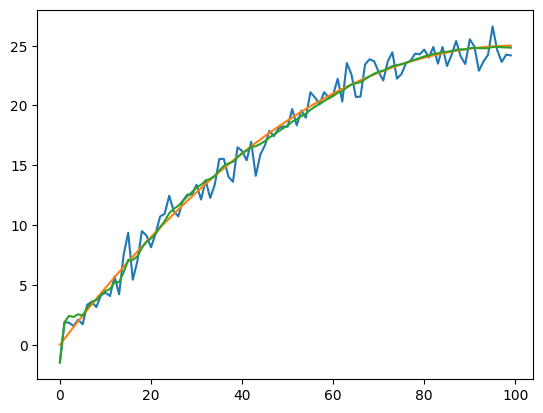

In [27]:
plt.plot(t,zs,t,zp,t,res[1:,0]);

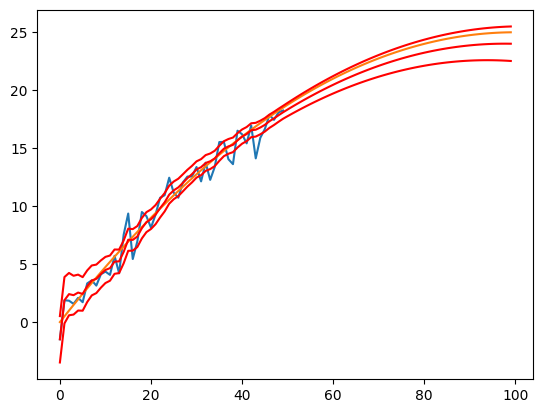

In [28]:
mu = mu0
p = p0

res = np.array([[mu[0],mu[1],np.sqrt(p[0,0]),np.sqrt(p[1,1])]])

ran = 50

for z in zs[:ran]:
    mu,p,_ = mikalman(mu,p,f,s,B,u,z,H,r)
    res = np.append(res,[[mu[0],mu[1],np.sqrt(p[0,0]),np.sqrt(p[1,1])]],axis=0)

for z in zs[ran:]:
    mu,p,_ = mikalman(mu,p,f,s,B,u,None,H,r)
    res = np.append(res,[[mu[0],mu[1],np.sqrt(p[0,0]),np.sqrt(p[1,1])]],axis=0)

# extraemos las varianzas de la estimación de posición
# para dibujar la banda de incertidumbre
plt.plot(t[:ran],zs[:ran],t,zp);
plt.plot(t,res[1:,0],t,res[1:,0] + 2*res[1:,2],t,res[1:,0] - 2*res[1:,2],color='red');

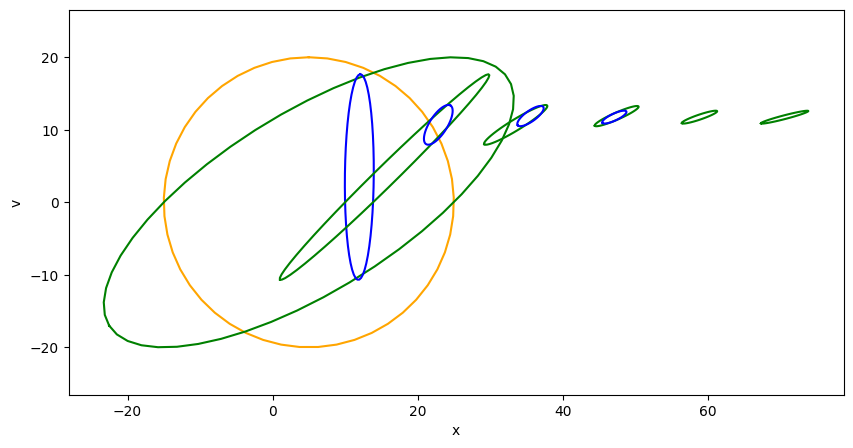

In [29]:
g0 = G(np.array([5,0]),
       np.array([[100, 0],
                 [0, 100]]))

def showkalman2(g,z):
    g1 = G( f @ g.m + B @ u  ,    f @ g.c @ f.T + s );
    m,c,_ = mikalman(g.m,g.c,f,s,B,u,z,H,r)
    g2 = G(m,c)
    plt.plot(*g1.ellipse().T,color='green');
    if z is not None:
        plt.plot(*g2.ellipse().T,color='blue');
    return g2

plt.figure(figsize=(10,5))
plt.plot(*g0.ellipse().T,color='orange');
g = g0
for z in [12,23,36,47,None,None]:
    g = showkalman2(g,z)
plt.axis('equal'); plt.xlabel('x'); plt.ylabel('v');

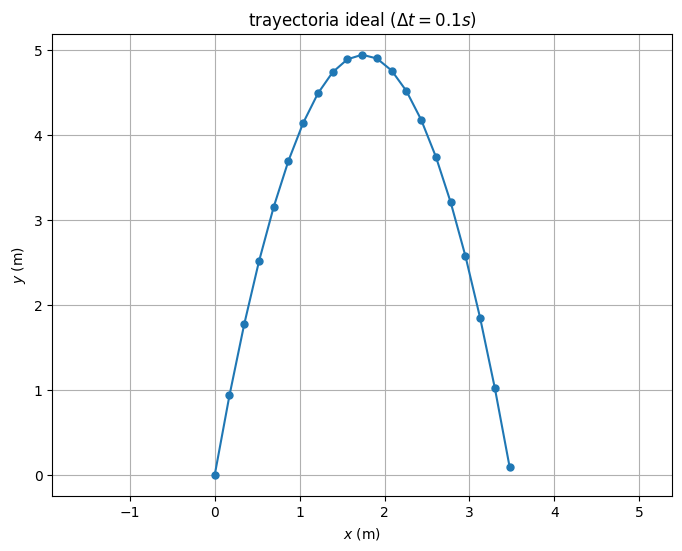

In [44]:
x0 = np.array([0,0])
angle = 80*degree
v0 = 10*np.array([np.cos(angle), np.sin(angle)])

a = np.array([0, - 9.8])
t = np.arange(0,2.01,0.1)

Z = xp,yp = col(x0)  + col(v0)* row(t) + 1/2 * col(a) * row(t**2)

plt.figure(figsize=(8,6))
plt.plot(xp,yp,'.-',markersize=10);
plt.axis('equal'); plt.grid(); plt.xlabel('$x$ (m)'); plt.ylabel('$y$ (m)');
plt.title('trayectoria ideal ($\\Delta t = 0.1s$)');

In [31]:
fps = 25
dt  = 1/fps

F = np.array(
    [1, 0,  dt,  0,
     0, 1,  0, dt,
     0, 0,  1,  0,
     0, 0,  0,  1 ]).reshape(4,4)


B = np.array(
         [dt**2/2, 0,
          0,       dt**2/2,
          dt,      0,
          0,       dt      ]).reshape(4,2)


H = np.array(
    [1,0,0,0,
     0,1,0,0]).reshape(2,4)

In [32]:
def evol(x,u):
    return F@x + B@u

In [33]:
s0 = np.hstack([x0,v0])

r = [s0]
s = s0
for k in range(round(2/dt)):
    s = evol(s,a)
    r.append(s)
    #print(s)
r = np.array(r)

In [34]:
xt,yt,*vs = r.T

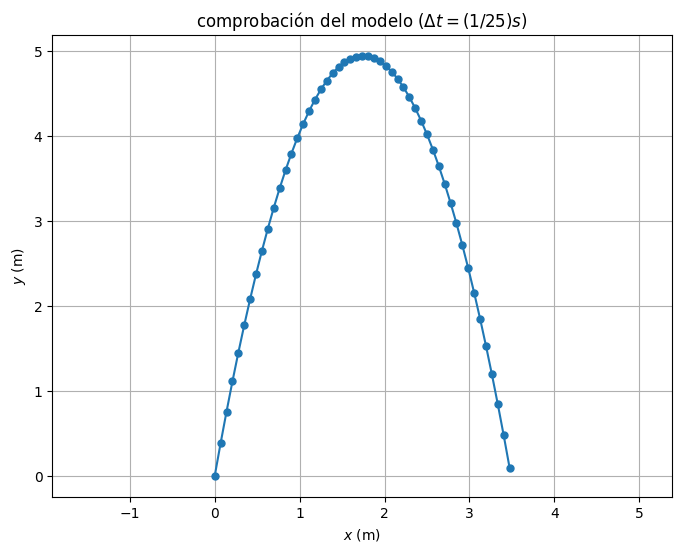

In [35]:
plt.figure(figsize=(8,6))
plt.plot(xt,yt,'.-',markersize=10); plt.axis('equal'); plt.grid();
plt.xlabel('$x$ (m)'); plt.ylabel('$y$ (m)');
plt.title('comprobación del modelo ($\\Delta t = (1/25) s$)');

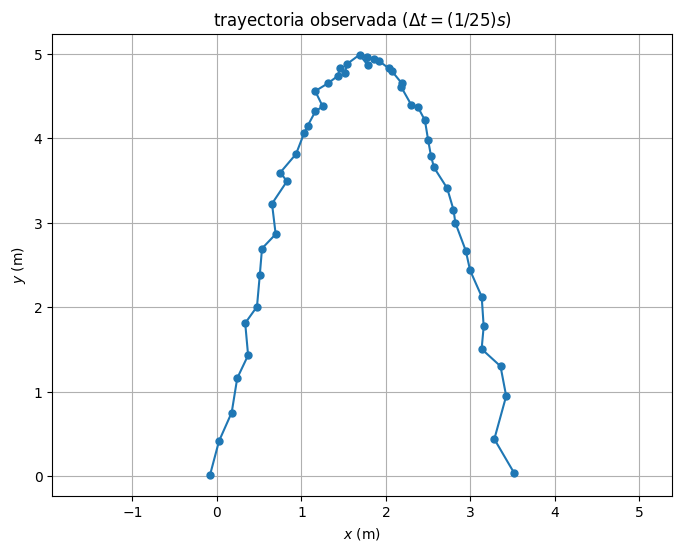

In [36]:
x0 = np.array([0,0])
angle = 80*degree
v0 = 10*np.array([np.cos(angle), np.sin(angle)])

a = np.array([0, - 9.8])
t = np.arange(0,2.01,dt)

noise = 0.05

# trayectoria verdadera (desconocida en realidad)
Zt = xt,yt = col(x0)  +  col(v0)* row(t) + 1/2 * col(a) * row(t**2)

# trayectoria observada
Z  = xo,yo = Zt + noise*np.random.randn(2,len(t))

plt.figure(figsize=(8,6))
plt.plot(xo,yo,'.-',markersize=10);
plt.axis('equal'); plt.grid(); plt.xlabel('$x$ (m)'); plt.ylabel('$y$ (m)');
plt.title('trayectoria observada ($\\Delta t = (1/25) s$)');

In [37]:
# estado que Kalman va actualizando. Este es el valor inicial

             # x, y, vx, vy
mu = np.array([0,0,0,0])
            # sus incertidumbres
P  = np.diag([100,100,100,100])**2
#res = [(mu,P,mu)]
res=[]
N = 15  # para tomar un tramo inicial y ver qué pasa si luego se pierde la observación

sigmaM = 0.001   # ruido del modelo
sigmaZ = 3*noise  # debería ser igual al ruido de media del proceso de imagen. 10 pixels pje.

Q = sigmaM**2 * np.eye(4)
R = sigmaZ**2 * np.eye(2)

In [38]:
                                    # z es la medida del centro de la pelota observada
                                    # mu es la estimación filtrada actualizada
for z in Z.T[1:N]:
    mu,P,pred = mikalman(mu,P,F,Q,B,a,z,H,R)
    res += [[mu,P,pred]]

for _ in range(50-N):
    mu,P,pred = mikalman(mu,P,F,Q,B,a,None,H,R)  # aquí solo continuamos la predicción
    res += [[mu,P,pred]]

In [39]:
xe = [mu[0] for mu,_,_ in res]             # coordenada x estimada
xu = [2*np.sqrt(P[0,0]) for _,P,_ in res]  # su incertidumbre

ye = [mu[1] for mu,_,_ in res]             # lo mismo para y
yu = [2*np.sqrt(P[1,1]) for _,P,_ in res]

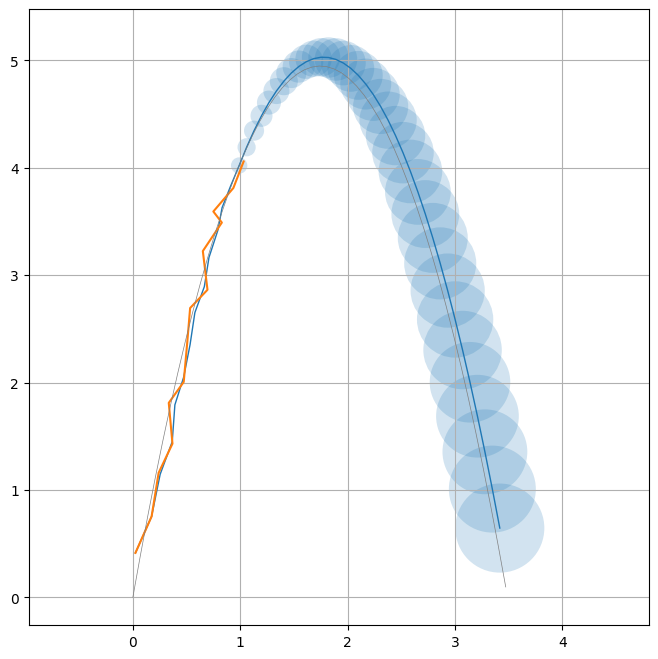

In [40]:
fig,ax = plt.subplots(figsize=(8,8))

for k in range(len(xe)):
    if (k >= N -2):
        ax.add_patch(Ellipse(xy=(xe[k],ye[k]), width=xu[k], height=yu[k], angle = 0, alpha=0.2))

plt.plot(xe,ye,lw=1)
plt.plot(xo[1:N],yo[1:N])#,xe,ze);
plt.plot(xt,yt,lw=0.5,color='gray'); plt.grid()
plt.axis('equal');

In [41]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
plt.close();
ax.set_xlim(( -1, 4))
ax.set_ylim(( 0, 5))

line1, = ax.plot([], [], lw=1)
line2, = ax.plot([],[])
line3, = ax.plot([],[],'.',markersize=15)
line4, = ax.plot([],[])
line5, = ax.plot([],[])
line6, = ax.plot(xt,yt,lw=0.5,color='gray')

mu0 = np.array([0,0,0,0])
            # sus incertidumbres 
P0  = np.diag([10,10,10,10])**2
#res = [(mu,P,mu)]

def animate(i):
    global mu,P
    N = i
    res=[]
    mu = mu0
    P  = P0
    for z in Z.T[1:N]:
        mu,P,pred = mikalman(mu,P,F,Q,B,a,z,H,R)
        #print(mu)
        res += [(mu,P,pred)]

    for _ in range(len(Z.T)-N):
        mu,P,pred = mikalman(mu,P,F,Q,B,a,None,H,R)  # aquí solo continuamos la predicción
        res += [(mu,P,pred)]


    xe = np.array([mu[0] for mu,_,_ in res])
    xu = np.array([2*np.sqrt(P[0,0]) for _,P,_ in res])

    ye = np.array([mu[1] for mu,_,_ in res])
    yu = np.array([2*np.sqrt(P[1,1]) for _,P,_ in res])

    line1.set_data(xe,ye)
    line2.set_data(xo[1:N],yo[1:N])
    line3.set_data([xo[max(0,N-1)]],[yo[max(0,N-1)]])
    line4.set_data(xe+xu,ye)
    line5.set_data(xe-xu,ye)

    return ()

ani = animation.FuncAnimation(fig, animate, init_func=lambda:[], frames=50, interval=4*1000/25, blit=True)
HTML(ani.to_jshtml())

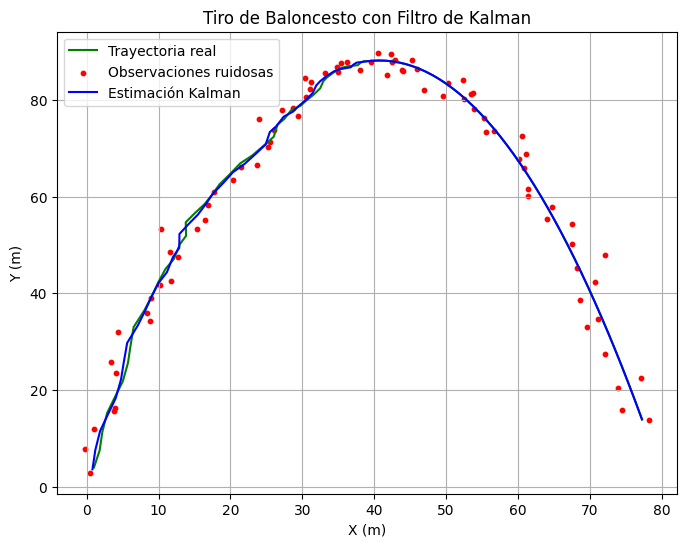

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def mikalman(mu, P, F, Q, B, u, z, H, R):
    mup = F @ mu + B @ u  # Predicción del estado
    pp  = F @ P @ F.T + Q  # Predicción de la incertidumbre
    zp = H @ mup  # Predicción de la medición
    
    if z is None:
        return mup, pp, zp  # Sin observación
    
    epsilon = z - zp  # Error de medición
    k = pp @ H.T @ np.linalg.inv(H @ pp @ H.T + R)  # Ganancia de Kalman
    new_mu = mup + k @ epsilon  # Corrección del estado
    new_P  = (np.eye(len(P)) - k @ H) @ pp  # Nueva incertidumbre
    return new_mu, new_P, zp

# Parámetros del sistema
dt = 0.1  # Intervalo de tiempo
F = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])  
B = np.array([[0], [0], [0], [dt]])  
u = np.array([-9.8])  # Aceleración por gravedad
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  
Q = np.eye(4) * 0.1  
R = np.eye(2) * 2  

# Estado inicial: posición (0,0), velocidad (10,15)
mu = np.array([0, 0, 10, 40])  
P = np.eye(4)  

# Simulación del tiro
num_steps = 82
true_positions = []
observed_positions = []
kalman_positions = []

for t in range(num_steps):
    # Simulamos la posición real (con gravedad)
    mu_real = F @ mu + B @ u  
    true_positions.append(mu_real[:2])  

    # Generamos una observación ruidosa
    z = H @ mu_real + np.random.multivariate_normal([0, 0], R)

    # Aplicamos el filtro de Kalman
    if (t <= 40):
        mu, P, zp = mikalman(mu, P, F, Q, B, u, z, H, R)
    else:
        mu, P, zp = mikalman(mu, P, F, Q, B, u, None, H, R)
    
    observed_positions.append(z)
    kalman_positions.append(mu[:2])

# Convertimos a arrays para graficar
true_positions = np.array(true_positions)
observed_positions = np.array(observed_positions)
kalman_positions = np.array(kalman_positions)

# 📊 Gráfica del resultado
plt.figure(figsize=(8, 6))
plt.plot(true_positions[:, 0], true_positions[:, 1], 'g-', label="Trayectoria real")
plt.scatter(observed_positions[:, 0], observed_positions[:, 1], color='r', label="Observaciones ruidosas", s=10)
plt.plot(kalman_positions[:, 0], kalman_positions[:, 1], 'b-', label="Estimación Kalman")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("Tiro de Baloncesto con Filtro de Kalman")
plt.grid()
plt.show()
